<a href="https://colab.research.google.com/github/Monoxido45/Active_learning_tests/blob/master/modules/simulacoes_active_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Simulações para active learning:** 

*   Primeiramente iremos mostrar o exemplo utilizado por Settles na coletânea da literatura de active learning:

In [39]:
# importando principais bibliotecas a serem utilizadas
import numpy as np
import pandas as pd

# para os graficos
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
import seaborn as sns
from scipy import stats

Geraremos um mistura de normais com certa interseção, mas com uma divisão clara:



In [43]:
# 400 amostras, 200 para cada lado
seed = 1200
n_class = 200
classes = np.concatenate([np.zeros(n_class), np.ones(n_class)])
np.random.shuffle(classes)

In [46]:
X = np.zeros((2*n_class, 2))
mu_0 = [-2, 0]
mu_1 = [2, 0]
cov = [[1, 0], [0, 1]] 
X[classes == 0, :] = np.random.multivariate_normal(mu_0, cov, 200)
X[classes == 1, :] = np.random.multivariate_normal(mu_1, cov, 200)

sim_data = pd.DataFrame(data = {'X1' : X[:, 0],
                                 'X2' : X[:, 1],
                                 'target':classes})

Em um gráfico 2D, teriamos a seguinte distribuição das classes:

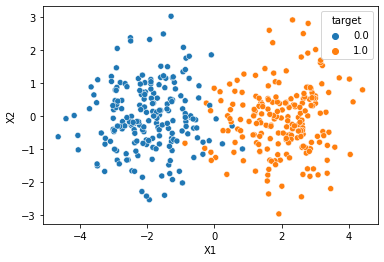

In [47]:
sns.scatterplot(data = sim_data, x = "X1", y = "X2", hue = 'target')
plt.show()

Tomando uma pequena amostra inicial de 5 observações, podemos inicializar uma regressão logística e random forest:

In [50]:
!pip install modAL
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from modAL import ActiveLearner, Committee
from modAL.uncertainty import uncertainty_sampling

rf = RandomForestClassifier(n_estimators = 150)
logis = LogisticRegression(penalty = 'none')

# declarando o learner para o random forest
learner_rf = ActiveLearner(
    estimator = rf,
    query_strategy = uncertainty_sampling
)

# declarando o learner para o logistica
learner_logis = ActiveLearner(
    estimator = logis,
    query_strategy = uncertainty_sampling
)


from sklearn.model_selection import train_test_split
X_train_total, X_test, y_train_total, y_test = train_test_split(X, classes, test_size = 0.2, random_state = 120, stratify = classes)
# fixando a semente
seed = 1450
np.random.seed(seed)

# setando as amostras iniciais:
# 20 para treinamento inicial
n_initial = 5
X_pool = np.copy(X_train_total)
y_pool = np.copy(y_train_total)
train_idx = np.random.choice(range(X_pool.shape[0]), size = n_initial, replace = False)
X_train = X_pool[train_idx]
y_train = y_pool[train_idx]

# reduzindo a pool
X_pool = np.delete(X_pool, train_idx, axis=0)
y_pool = np.delete(y_pool, train_idx)

# tomando uma pool para RF e outra para logistica
X_pool_rf, X_pool_random_rf = np.copy(X_pool), np.copy(X_pool)
y_pool_rf, y_pool_random_rf = np.copy(y_pool), np.copy(y_pool)

X_pool_logis, X_pool_random_logis = np.copy(X_pool), np.copy(X_pool)
y_pool_logis, y_pool_random_logis = np.copy(y_pool), np.copy(y_pool)

learner_rf.teach(X_train, y_train)
learner_logis.teach(X_train, y_train)

In [51]:
seed = 1250
np.random.seed(seed)
n_queries = 100
unqueried_score_rf = learner_rf.score(X_test, y_test)
unqueried_score_random= learner_logis.score(X_test, y_test)
performance_history_rf = [unqueried_score_rf]
performance_history_rf_random = [unqueried_score_rf]
performance_history_logis = [unqueried_score_random]
performance_history_logis_random = [unqueried_score_random]
from sklearn.base import clone


learner_rf_random, learner_logis_random = clone(learner_rf), clone(learner_logis)
for index in range(n_queries):
  # obtendo o indice para perguntar os labels
  query_index_rf, query_instance_rf = learner_rf.query(X_pool_rf)
  query_index_knn, query_instance_knn = learner_logis.query(X_pool_rf)

  # ensinando o activelearner
  # Random Forest
  X_sel, y_sel = X_pool_rf[query_index_rf].reshape(1, -1), y_pool_rf[query_index_rf].reshape(1, )
  learner_rf.teach(X = X_sel, y = y_sel)
  X_pool_rf, y_pool_rf = np.delete(X_pool_rf, query_index_rf, axis=0), np.delete(y_pool_rf, query_index_rf)
  
  # logistica
  X_sel, y_sel = X_pool_logis[query_index_knn].reshape(1, -1), y_pool_logis[query_index_knn].reshape(1, )
  learner_logis.teach(X = X_sel, y = y_sel)
  X_pool_logis, y_pool_logis = np.delete(X_pool_logis, query_index_knn, axis=0), np.delete(y_pool_logis, query_index_knn)

  # acuracia para cada modelo com a nova observacao
  model_accuracy_rf = learner_rf.score(X_test, y_test)
  model_accuracy_knn = learner_logis.score(X_test, y_test)
  
  # historico de performance para ambos
  performance_history_rf.append(model_accuracy_rf)
  performance_history_logis.append(model_accuracy_knn)

  # amostra aleatoria dos indices
  sample_idx_rf = np.random.choice(range(len(X_pool_random_rf)), size = 1, replace = False)
  sample_idx_logis = np.random.choice(range(len(X_pool_random_logis)), size = 1, replace = False)

  # ensinando o activelearner
  # Random Forest
  X_sel, y_sel = X_pool_random_rf[sample_idx_rf].reshape(1, -1), y_pool_rf[sample_idx_rf].reshape(1, )
  learner_rf_random.teach(X = X_sel, y = y_sel)
  X_pool_random_rf, y_pool_random_rf = np.delete(X_pool_random_rf, sample_idx_rf, axis=0), np.delete(y_pool_random_rf, sample_idx_rf)
  
  # logistica
  X_sel, y_sel = X_pool_random_logis[sample_idx_logis].reshape(1, -1), y_pool_random_logis[sample_idx_logis].reshape(1, )
  learner_logis_random.teach(X = X_sel, y = y_sel)
  X_pool_random_logis, y_pool_rf = np.delete(X_pool_random_logis, sample_idx_rf, axis=0), np.delete(y_pool_random_logis, sample_idx_rf)

  # acuracia para cada modelo com a nova observacao
  model_accuracy_rf = learner_rf_random.score(X_test, y_test)
  model_accuracy_logis = learner_logis_random.score(X_test, y_test)
  
  # historico de performance para ambos
  performance_history_rf_random.append(model_accuracy_rf)
  performance_history_logis_random.append(model_accuracy_logis)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


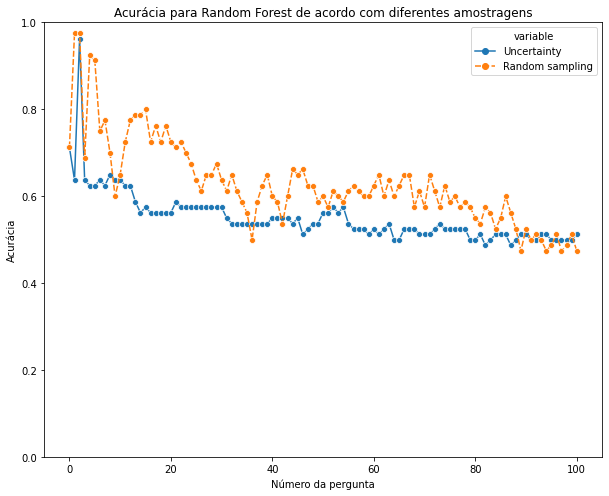

In [55]:
plt.figure(figsize = (10, 8))

rf_data = pd.DataFrame(data = {'Uncertainty': performance_history_rf,
                               'Random sampling': performance_history_rf_random,
                            'Query': np.arange(0,101)})

melt_data = pd.melt(rf_data, id_vars = ['Query'], value_vars = ['Uncertainty', 'Random sampling'])

sns.lineplot(data = melt_data, x = "Query", y = "value", markers=["o", "o"], hue = "variable", style="variable") 
plt.title("Acurácia para Random Forest de acordo com diferentes amostragens")
plt.xlabel("Número da pergunta")
plt.ylabel("Acurácia")
plt.ylim(0, 1)
plt.show()

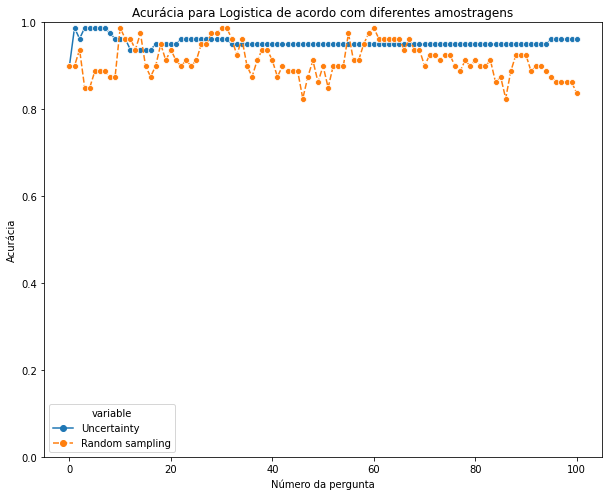

In [56]:
plt.figure(figsize = (10, 8))

rf_data = pd.DataFrame(data = {'Uncertainty': performance_history_logis,
                               'Random sampling': performance_history_logis_random,
                            'Query': np.arange(0,101)})

melt_data = pd.melt(rf_data, id_vars = ['Query'], value_vars = ['Uncertainty', 'Random sampling'])

sns.lineplot(data = melt_data, x = "Query", y = "value", markers=["o", "o"], hue = "variable", style="variable") 
plt.title("Acurácia para Logistica de acordo com diferentes amostragens")
plt.xlabel("Número da pergunta")
plt.ylabel("Acurácia")
plt.ylim(0, 1)
plt.show()